<H3> Init </H3>

In [137]:
%reload_ext autoreload
%autoreload 2
#ignore warnings.
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

<H3> Imports and Constants </H3>

In [138]:
#imports
import pandas as pd
import numpy as np
import os, sys, itertools as it, random
import datetime as dt
import csv
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score, recall_score, balanced_accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, log_loss, roc_curve, brier_score_loss

#path
sys.path.append('../modules')

<H3> File Configurations </H3>

In [139]:
def load_configurations():
    #configurations of prediction file [column header, format, range etc.]
    c_p={
            'dir': '../newdata/predictions/',
            'file': 'prediction_shift_0.csv',
            'number_of_samples': 500, #don't bother about this, this is just used while generating synthetic data
            'id_column': 'person_id',
            'id_format': int,
            'date_column': 'Date',
            'date_format': 'datetime', #options: 'ym', 'y-m-d', datetime
            'start_date': '2016-01-01', #first month is January 2016
            'end_date': '2018-01-01', #last month is December 2017
            'model_columns': ['lin_reg', 'rand_forest', 'xg_boost', 'sgmm'],
            'model_format': int
        }

    #configurations of referral file [column header, format, range etc.]
    c_r={
            'dir': '../newdata/referrals/',
            'file': 'referral.csv',
            'number_of_samples': 25, #don't bother about this, this is just used while generating synthetic data
            'start_date': '2016-01-01',
            'end_date': '2018-01-01',
            'id_column': 'person_id',
            'id_format': int,
            'date_column': 'Date',
            'date_format': 'ym', #options: 'ym', 'y-m-d', datetime
            'day_to_evaluate': 1 #evaluate on day 1 of each month
        }
    
    #configurations for the experiment
    c_e={
            'experiment': 'Version 1.0',
            'dir': '../newdata/results/',
            'file': 'results.csv',
            'thresholding': [0.5, 0.6],
            'top_k': [50, 60],
            'window': [[0,3], [-3,6], [0,12]],
            'eval_date': pd.to_datetime(dt.date(2017,1,1)),
            'eval_method': 'top_k' #options: 'top_k' or 'thresholding'
        }
    
    return c_p, c_r, c_e

<H3> HELPER FUNCTIONS </H3>

In [140]:
#generate random date between a range
#input in datetime.date format
#mutable obj integrity checked
def generate_random_date(start_date, end_date, iteration, date_format):
    date_list = []
    seed = 0
    for i in range(iteration):
        s_date = datetime.strptime(start_date, '%Y-%m-%d')
        e_date = datetime.strptime(end_date, '%Y-%m-%d')
        time_between_dates = e_date - s_date
        days_between_dates = time_between_dates.days
        random.seed(seed)
        random_number_of_days = random.randrange(days_between_dates)
        random_date = s_date + dt.timedelta(days=random_number_of_days) #this is datetime object
        if date_format=='y-m-d':
            random_date = random_date.strftime('%Y-%m-%d') #string format output
        elif date_format=='ym':
            random_date = int(random_date.strftime("%Y%m"))
        date_list.append(random_date)
        seed += 1
    
    return date_list

In [141]:
#preprocess referral dates
#convert any day in any month to the first day of that month in REFERRAL data
#mutable obj integrity checked
#ref_copy passed by reference, changed directly
def convert_dates_ref(ref_copy, c_r): #use if c_r['date_format'] is 'y-m-d' or datetime
    ref_date_column = ref_copy[c_r['date_column']]
    for i in range(len(ref_date_column)):
        formatted_date = ref_date_column[i]
        new_formatted_date = datetime(formatted_date.year, formatted_date.month, c_r['day_to_evaluate'])
        ref_copy.at[i,c_r['date_column']] = new_formatted_date


In [142]:
#convert top k probability of a target to 1, O/W to 0 mapping
#target was a pd.series, kept intact
#mutable obj integrity checked
def prob_to_bin(target, k):
    ind=np.argpartition(target, -k)[-k:]
    target_bin=np.zeros(len(target))
    target_bin[ind]=1
    
    return target_bin
#return local variable, it does not get lost, stays in heap as long as there is a reference to it. O/W garbage collector.

In [143]:
#data = dataframe, file='/relative_path/to/file'
#mutable obj integrity checked
def dataframe_to_csv(data, file, append=False, index=False, metadata=None):
    
        if not np.isnan(metadata["num_samples"]):
            if append==True and os.path.exists(file):
                with open(file, "a", newline='') as csv_file:
                    writer = csv.writer(csv_file)
                    writer.writerow(["Model Name:",metadata["model_name"]])
                    writer.writerow(["Number of Experimental Samples: ",str(metadata["num_samples"])])
                    data.to_csv(csv_file, index=index, float_format= '%8.5f', mode='a')
            else:
                with open(file, "w", newline='') as csv_file:
                    writer = csv.writer(csv_file)
                    writer.writerow(["Model Name:",metadata["model_name"]])
                    writer.writerow(["Number of Experimental Samples: ",str(metadata["num_samples"])])
                    data.to_csv(csv_file, index=index, float_format= '%8.5f', mode='a')


In [144]:
'''
pd.to_Datetime(anything) = create datetime object
datetime.strptime(string) -> datetime object
datetime.strftime(datetime) -> string in different formats
'''
#give a 'ym' column, it will convert all of them to datetime
#mutable obj integrity checked
#updated mutable dataframe passed by reference
def ym_to_datetime(config, df): #ym to datetime
    label = config['date_column']
    df[label] = df[label].astype(str)
    for i in range(df[label].size):
        df[label][i] = df[label][i][:4] + '-' + df[label][i][4:] + '-01' #choosing the first month of the day
    df[label] = pd.to_datetime(df[label])
    #return df
    

<H3> Generate Synthetic Data </H3>

In [145]:
#mutable obj integrity checked
#no changes in c_p, c_r
def generate_synthetic_ground_truth_data(c_p, c_r):
    seed = 0
    np.random.seed(seed)
    patients = pd.Series([x for x in np.random.randint(0, c_p['number_of_samples']*2, c_r['number_of_samples'])])
    patients = patients.sort_values(ascending=True).reset_index(drop=True)
    date = pd.Series([d for d in generate_random_date(c_r['start_date'], c_r['end_date'], c_r['number_of_samples'], c_r['date_format'])])
    data = pd.DataFrame({c_r['id_column']:patients, c_r['date_column']:date})
    dataframe_to_csv(data, c_r['dir']+c_r['file'])


In [146]:
#mutable obj integrity checked
#no changes in c_p
def generate_synthetic_prediction_data(c_p):
    patients = pd.Series(range(0, c_p['number_of_samples'])) #500
    
    if c_p['date_format']=='ym':
        date = pd.date_range(c_p['start_date'], c_p['end_date'], freq='MS').strftime("%Y%m").astype(int) #25
    elif c_p['date_format']=='y-m-d':
        date = pd.date_range(c_p['start_date'], c_p['end_date'], freq='MS').strftime("%Y-%m-%d")
    else:
        date = pd.date_range(c_p['start_date'], c_p['end_date'], freq='MS')
    
    data = pd.DataFrame(list(it.product(patients,date)),columns=[c_p['id_column'],c_p['date_column']])
    seed = 0
    for model in c_p['model_columns']:
        np.random.seed(seed)
        data[model] = pd.Series(np.random.random((data.shape[0])))
        seed+=1
    
    dataframe_to_csv(data, c_p['dir']+c_p['file'])
    

<H3> Score Class </H3>

In [147]:
class Score:
    
    def __init__(self, model_name):
        self.model_name = model_name
        self.experimental_samples = -1
        self.precision = {}
        self.recall = {}
        self.accuracy = {}
        self.balanced_accuracy = {}
        self.f1_score = {}
        self.roc_auc_score = {} 
        self.log_loss = {}
        self.brier_score_loss = {}
    
    def get_precision(self, y_true, y_predict, average='binary'):
        return precision_score(y_true, y_predict, average)
    
    def get_recall(self, y_true, y_predict, average='binary'):
        return recall_score(y_true, y_predict, average)
    
    def get_accuracy(self, y_true, y_predict):
        return recall_score(y_true, y_predict)
    
    def get_balanced_accuracy(self, y_true, y_predict):
        return balanced_accuracy_score(y_true, y_predict)
    
    def get_f1_score(self, y_true, y_predict, average='binary'):
        return f1_score(y_true, y_predict, average='binary')
    
    def get_roc_auc_score(self, y_true, y_predict):
        return roc_auc_score(y_true, y_predict)
    
    def get_log_loss(self, y_true, y_predict):
        return log_loss(y_true, y_predict)

    def get_brier_score_loss(self, y_true, y_predict):
        return brier_score_loss(y_true, y_predict)
    
        

<H3> Evaluation </H3>

In [148]:
#cp, c_r, c_e are all mutable
#mutable obj integrity checked
def evaluate(c_p, c_r, c_e):
    
    eval_method = c_e['eval_method']      
    
    referral = pd.read_csv(c_r['dir'] + c_r['file'])
    ref_copy = referral.copy() #shallow copy
    
    #convert_dates_ref(c_r)
    if c_r['date_format']=='ym':
        ym_to_datetime(c_r, ref_copy) #passing reference of mutable ref_copy, will be directly edited
    else:
        ref_copy[c_r['date_column']] = pd.to_datetime(ref_copy[c_r['date_column']])
        convert_dates_ref(ref_copy, c_r)
    
    ref_copy['target'] = pd.Series(np.ones(c_r['number_of_samples'], dtype=float))
    ref_copy = ref_copy.pivot_table(index=c_r['id_column'], columns=c_r['date_column'], values='target', aggfunc='sum')
    ref_copy = ref_copy.fillna(0)

    #now both pred_copy['Date'] and ref_copy['Date'] is in Datetime format instead of previous String format
    
    prediction = pd.read_csv(c_p['dir'] + c_p['file'])
    pred_copy = prediction.copy()
        
    #change date from ym to ymd here
    if c_p['date_format']=='ym':
        ym_to_datetime(c_p, pred_copy) #passing reference of mutable pred_copy, will be directly edited
    else:
        pred_copy[c_p['date_column']] = pd.to_datetime(pred_copy[c_p['date_column']])
        
    #now both ref_copy and pred_copy are datetime
    
    pred_copy = pred_copy.loc[pred_copy[c_p['date_column']]==c_e['eval_date']]
    
    #if all models predicts -1, then I can safely drop patient-month-date row with -1 predictions here
    #select rows, where the first model is not -1 (all model predicts -1)
    all_model_list = c_p['model_columns']
    pred_copy = pred_copy[pred_copy[all_model_list[0]]!=-1]
    
    all_model_evaluations = {} #{'model_name':score class object for that model}
        
    #now branch out for each model
    for model in all_model_list:
        
        evaluated_model_obj = Score(model)
        
        #calculate for each window
        for window in c_e['window']:
            
            #taking negative window into consideration
            if(window[0]<0):
                start = c_e['eval_date'] - pd.DateOffset(months=(-1)*window[0])
            else:
                start = c_e['eval_date'] + pd.DateOffset(months=window[0])
                
            end = c_e['eval_date'] + pd.DateOffset(months=window[1])
            
            sl=slice(start,end)
            y_true = ref_copy.loc[:,sl] #also a shallow copy
            
            #aggregate referrals
            y_true = y_true.sum(axis=1)
            
            #aggregated referral map to 1 if >1
            y_true[y_true>1] = 1
            
            #for the time being, all ref patients are in pred_list. 
            #Change random.randint upper_range in data_generate to tweak
            y_true=y_true[y_true.index.isin(pred_copy[c_p['id_column']])]
            
            y_true=y_true.append(pd.Series(0,index=set(pred_copy[c_p['id_column']])-set(y_true.index))).sort_index()
        
            #their size have to be same -- TO USE the built in metric functions
            if pred_copy.shape[0]!=len(y_true):
                print("ERROR: PREDICTION AND ACTUAL DATAFRAME HAVE DIFFERENT NUMBERS.  PREDICTION:",
                      pred_copy.shape[0], " EVALUATION: ",len(y_true))
                break
            
            #now thresholding method
            if eval_method=='top_k':
                for k_values in c_e['top_k']:
                    label = model+'_window_['+str(window[0])+','+str(window[1])+']_'+eval_method + '_@' + str(k_values)
                    pred_copy[label] = prob_to_bin(pred_copy[model], k_values)
                    #model score for this (window,k) update
                    update_model_score(model, evaluated_model_obj, label, y_true, pred_copy)
    
            elif eval_method == 'thresholding':
                for thresholds in c_e['thresholding']:
                    label = model+'_window_['+str(window[0])+','+str(window[1])+']_'+eval_method + '_@' + str(thresholds)
                    pred_copy[label] = np.where(pred_copy[model] > thresholds, 1, 0)
                    #model score for this (window,threshold) update
                    update_model_score(model, evaluated_model_obj, label, y_true, pred_copy)
            
        all_model_evaluations.update({model:evaluated_model_obj})
    
    return all_model_evaluations

In [149]:
#mutable obj integrity checked
#evaluated_model_obj changed as requirement
def update_model_score(model, evaluated_model_obj, label, y_true, pred_copy):
    
    precision = evaluated_model_obj.get_precision(y_true.values, pred_copy[label].values)
    evaluated_model_obj.precision.update({label:precision})

    recall = evaluated_model_obj.get_recall(y_true.values, pred_copy[label].values)
    evaluated_model_obj.recall.update({label:recall})

    accuracy = evaluated_model_obj.get_accuracy(y_true.values, pred_copy[label].values)
    evaluated_model_obj.accuracy.update({label:accuracy})

    balanced_accuracy = evaluated_model_obj.get_balanced_accuracy(y_true.values, pred_copy[label].values)
    evaluated_model_obj.balanced_accuracy.update({label:balanced_accuracy})

    f1_score = evaluated_model_obj.get_f1_score(y_true.values, pred_copy[label].values)
    evaluated_model_obj.f1_score.update({label:f1_score})

    #these will take predicted probabilites, not thresholded binaries

    log_loss = evaluated_model_obj.get_log_loss(y_true.values, pred_copy[model].values)
    evaluated_model_obj.log_loss.update({label:log_loss})

    roc_auc_score = evaluated_model_obj.get_roc_auc_score(y_true.values, pred_copy[model].values)
    evaluated_model_obj.roc_auc_score.update({label:roc_auc_score})
    
    brier_score_loss = evaluated_model_obj.get_brier_score_loss(y_true.values, pred_copy[model].values)
    evaluated_model_obj.brier_score_loss.update({label:brier_score_loss})
    
    #add number of samples used by this model
    evaluated_model_obj.experimental_samples = y_true.shape[0]
    
    

<H3> Present Evaluation </H3>

In [150]:
#mutable obj integrity checked
def evaluation_to_dataframe(model_name, model_obj):
    #all dictionaries with different windows
    precision = model_obj.precision
    recall = model_obj.recall
    accuracy = model_obj.accuracy
    balanced_accuracy = model_obj.balanced_accuracy
    f1_score = model_obj.f1_score
    log_loss = model_obj.log_loss
    roc_auc_score = model_obj.roc_auc_score
    brier_score_loss = model_obj.brier_score_loss
    number_of_experimental_samples = model_obj.experimental_samples
    
    metric_name = ['precision', 'recall', 'accuracy', 'balanced_accuracy', 'f1_score', 'log_loss', 'roc_auc_score', 'brier_score_loss']
    metric_value = [precision, recall, accuracy, balanced_accuracy, f1_score, log_loss, roc_auc_score, brier_score_loss]
    
    data = pd.DataFrame(metric_value, index=metric_name)
    
    return data, number_of_experimental_samples
    

In [151]:
#mutable obj integrity checked
#takes dataframe as input. Displays and plots it.
def visualize_result(data, table=False, plot=False):
    if display:
        pd.options.display.float_format = '{:10.5f}'.format
        display(data)
    if plot:
        data.plot.bar(figsize=(12,6))
        plt.show()

In [152]:
#generate plottable dataframe from whole result: evaluation_to_dataframe() helper function
#visualize result (if visual==True): visualize_performance() helper_function
#save result to CSV file: Use dataframe_to_csv() helper function
#mutable obj integrity checked
def present_evaluation(c_e, all_model_evaluations, visual=False, save=False):
    
    #result file
    result_file = c_e['dir']+c_e['file']
    
    #clear if there is already any result file previously (from previous run/experiment), 
    #otherwise it will just keep appending, as opening in append mode
    if os.path.exists(result_file):
        os.remove(result_file)
    
    #run everything
    
    model_count = 0
    for model in all_model_evaluations:
        model_name = model
        data, number_of_experimental_samples = evaluation_to_dataframe(model, all_model_evaluations[model])
        metadata = {"model_name":model_name, "num_samples":number_of_experimental_samples}
        if visual==True:
            visualize_result(data, table=True, plot=True)
        if save==True:
            print("Number of Experimental Samples: ", number_of_experimental_samples)
            if model_count==0:
                dataframe_to_csv(data, result_file, append=False, index=True, metadata=metadata)
            else:
                dataframe_to_csv(data, result_file, append=True, index=True, metadata=metadata)
            print("File Saved Successfully!")
        model_count +=1
    
    

<H2> MAIN </H2>

,"lin_reg_window_[0,3]_top_k_@50","lin_reg_window_[0,3]_top_k_@60","lin_reg_window_[-3,6]_top_k_@50","lin_reg_window_[-3,6]_top_k_@60","lin_reg_window_[0,12]_top_k_@50","lin_reg_window_[0,12]_top_k_@60"
precision,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
recall,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
accuracy,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
balanced_accuracy,0.44929,0.43915,0.44919,0.43902,0.44898,0.43878
f1_score,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
log_loss,0.96338,0.96338,0.96361,0.96361,0.97243,0.97243
roc_auc_score,0.47667,0.47667,0.48984,0.48984,0.31143,0.31143
brier_score_loss,0.32015,0.32015,0.32027,0.32027,0.32387,0.32387


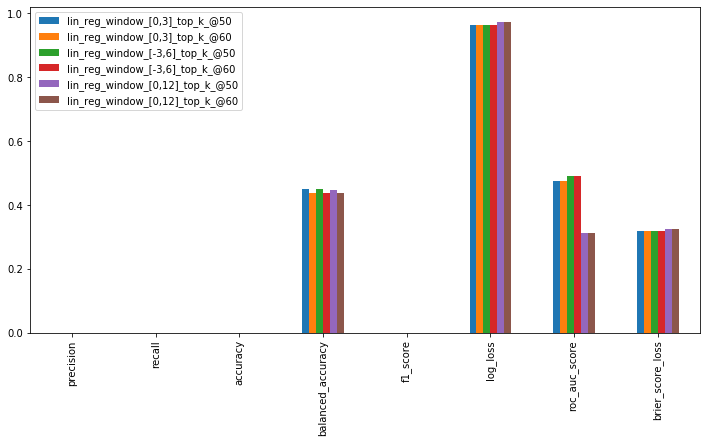

Number of Experimental Samples:  495
File Saved Successfully!


,"rand_forest_window_[0,3]_top_k_@50","rand_forest_window_[0,3]_top_k_@60","rand_forest_window_[-3,6]_top_k_@50","rand_forest_window_[-3,6]_top_k_@60","rand_forest_window_[0,12]_top_k_@50","rand_forest_window_[0,12]_top_k_@60"
precision,0.00000,0.00000,0.02000,0.01667,0.00000,0.00000
recall,0.00000,0.00000,0.33333,0.33333,0.00000,0.00000
accuracy,0.00000,0.00000,0.33333,0.33333,0.00000,0.00000
balanced_accuracy,0.44929,0.43915,0.61687,0.60671,0.44898,0.43878
f1_score,0.00000,0.00000,0.03774,0.03175,0.00000,0.00000
log_loss,0.96094,0.96094,0.95503,0.95503,0.96681,0.96681
roc_auc_score,0.51623,0.51623,0.66531,0.66531,0.36980,0.36980
brier_score_loss,0.32073,0.32073,0.31892,0.31892,0.32342,0.32342


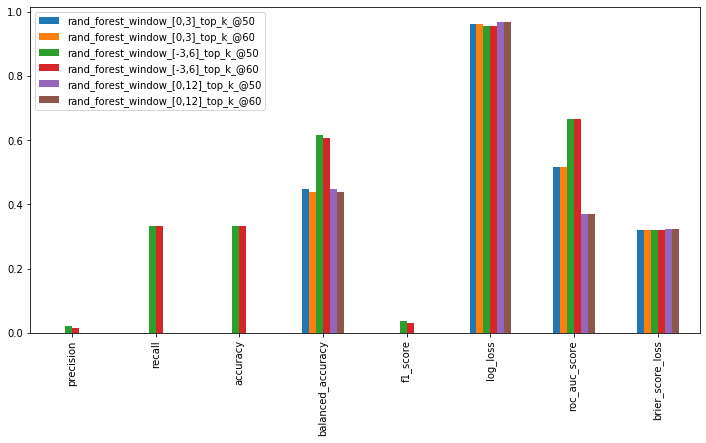

Number of Experimental Samples:  495
File Saved Successfully!


,"xg_boost_window_[0,3]_top_k_@50","xg_boost_window_[0,3]_top_k_@60","xg_boost_window_[-3,6]_top_k_@50","xg_boost_window_[-3,6]_top_k_@60","xg_boost_window_[0,12]_top_k_@50","xg_boost_window_[0,12]_top_k_@60"
precision,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
recall,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
accuracy,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
balanced_accuracy,0.44929,0.43915,0.44919,0.43902,0.44898,0.43878
f1_score,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
log_loss,1.01778,1.01778,1.02054,1.02054,1.02221,1.02221
roc_auc_score,0.41582,0.41582,0.34553,0.34553,0.37918,0.37918
brier_score_loss,0.33895,0.33895,0.34015,0.34015,0.34061,0.34061


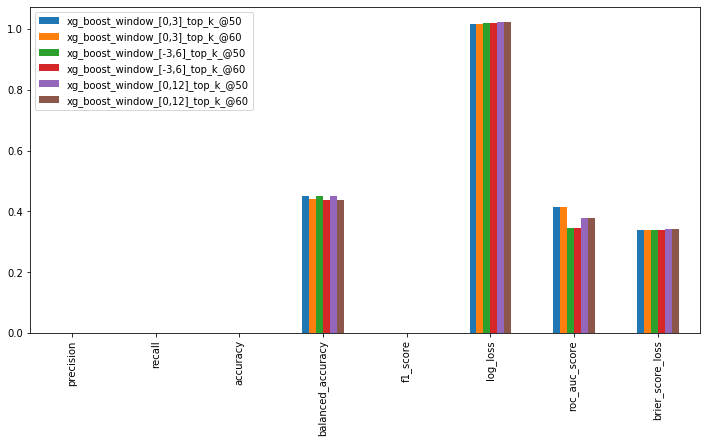

Number of Experimental Samples:  495
File Saved Successfully!


,"sgmm_window_[0,3]_top_k_@50","sgmm_window_[0,3]_top_k_@60","sgmm_window_[-3,6]_top_k_@50","sgmm_window_[-3,6]_top_k_@60","sgmm_window_[0,12]_top_k_@50","sgmm_window_[0,12]_top_k_@60"
precision,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
recall,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
accuracy,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
balanced_accuracy,0.44929,0.43915,0.44919,0.43902,0.44898,0.43878
f1_score,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
log_loss,0.96944,0.96944,0.96925,0.96925,0.96901,0.96901
roc_auc_score,0.48682,0.48682,0.50610,0.50610,0.51224,0.51224
brier_score_loss,0.32294,0.32294,0.32285,0.32285,0.32271,0.32271


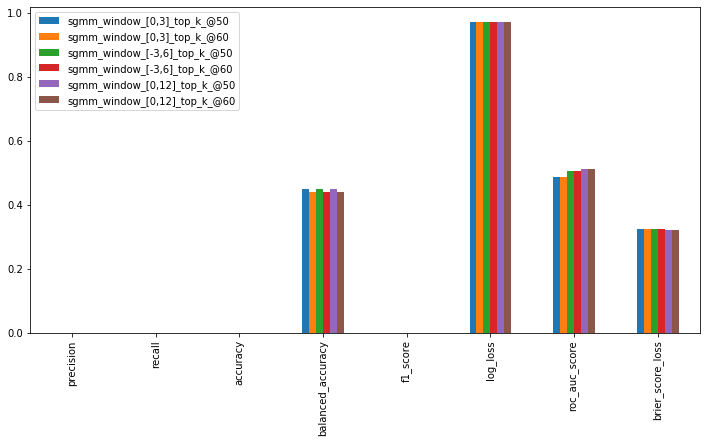

Number of Experimental Samples:  495
File Saved Successfully!


In [153]:
#pd.set_option('display.max_rows', None) to show all the rows of a dataframe
if __name__ == "__main__":
    c_p, c_r, c_e = load_configurations()
    #generate_synthetic_ground_truth_data(c_p, c_r)
    #generate_synthetic_prediction_data(c_p)
    all_model_evaluations = evaluate(c_p, c_r, c_e)
    
    '''
    keep visual=True if you want to see data + plots
    keep save=True if you want to save the data into a CSV file
    '''
    present_evaluation(c_e, all_model_evaluations, visual=True, save=True) 
    